## Changing the hyperparameters

Notebook looking at the effect of changing the noise_var on emulator predictions

In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
simnum=101

In [5]:
archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

emu2=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=archive,
                                drop_tau_rescalings=True,set_noise_var=1e-10,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1592 points
Optimised
Training GP on 1592 points
Optimised


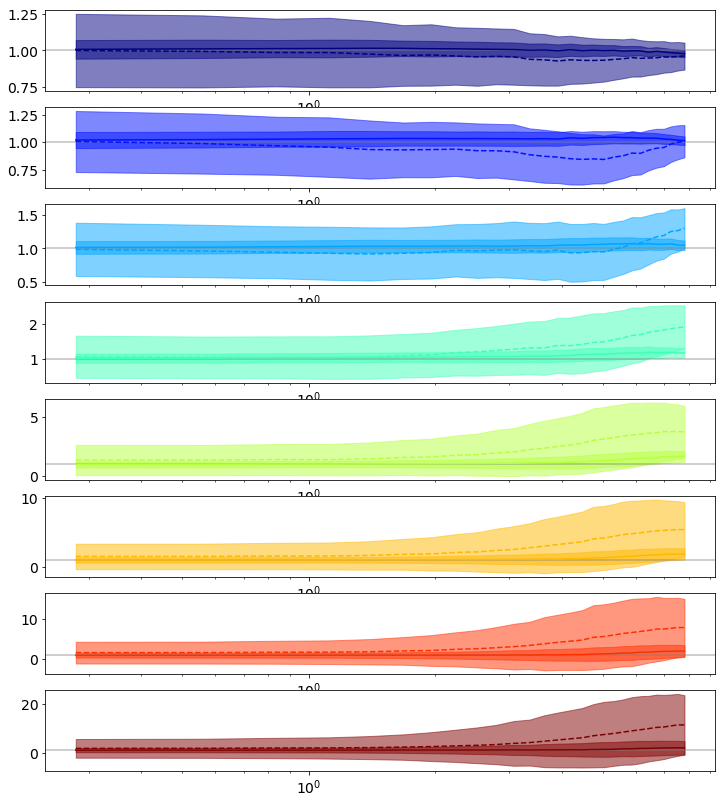

In [8]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid")
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.xscale("log")

In [11]:
emu_custom=copy.deepcopy(emu)

In [12]:
custom_hyperparams=np.array([1.94841635e+01, 4.81181544e+01, 6.28790536e-01, 1.16828739e-10])

In [13]:
emu_custom.load_hyperparams(custom_hyperparams)

In the following cell, we compare training a set of hyperparams with the intial noise var at 1e-3, but changing this by hand to 1-e10 and leaving all other hyperparameters the same

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


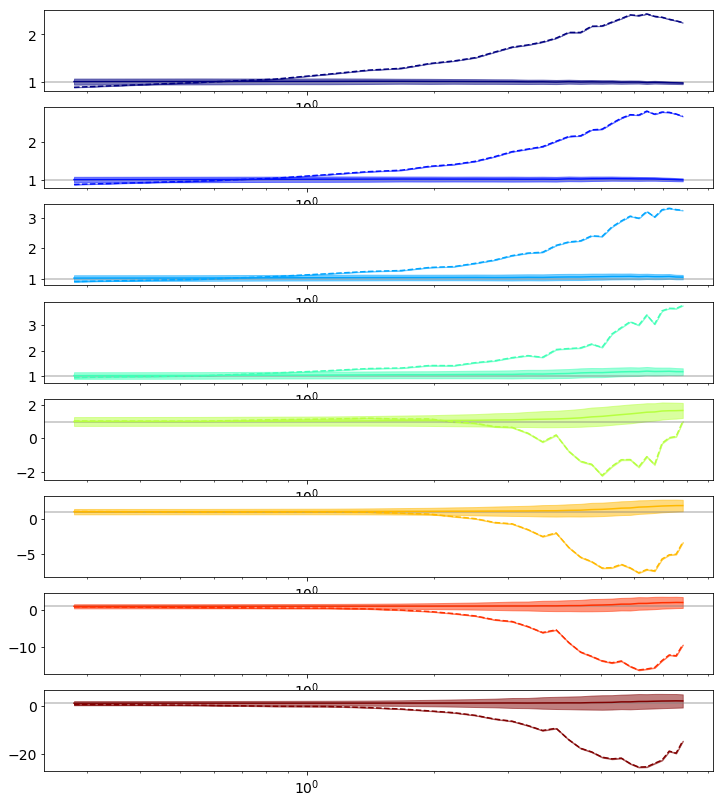

In [16]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu_custom.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    print(emu.check_in_hull(emu_call))
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid")
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.xscale("log")

In [ ]:
emu.gp.to_dict(False)

In [9]:
emu.gp.param_array

array([1.94841635e+01, 4.81181544e+01, 6.28790536e-01, 1.16828739e-02])

In [10]:
emu2.gp.param_array

array([8.32949319e+00, 2.47036892e+00, 1.83280234e-01, 1.94199024e-10])

In [ ]:
## First change linear variance
emu_params=copy.deepcopy(emu.gp.param_array)
emu_params[0]*=0.9
emu2.load_hyperparams(emu_params)

In [ ]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/pred_2,color=col,linestyle="dashed")
    ## Plot z with same limits
    plt.plot(k_test,err/err_2,color=col,linestyle="-.")
    plt.xscale("log")

In [ ]:
## Now change RBF kernel variance
emu_params=copy.deepcopy(emu.gp.param_array)
emu_params[1]*=0.9
emu2.load_hyperparams(emu_params)

In [ ]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/pred_2,color=col,linestyle="dashed")
    ## Plot z with same limits
    plt.plot(k_test,err/err_2,color=col,linestyle="-.")
    plt.xscale("log")

In [ ]:
## Now change RBF correlation length
emu_params=copy.deepcopy(emu.gp.param_array)
emu_params[2]*=0.9
emu2.load_hyperparams(emu_params)

In [ ]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/pred_2,color=col,linestyle="dashed")
    ## Plot z with same limits
    plt.plot(k_test,err/err_2,color=col,linestyle="-.")
    plt.xscale("log")

In [ ]:
## Now change the noise variable
emu_params=copy.deepcopy(emu.gp.param_array)
emu_params[3]*=0.9
emu2.load_hyperparams(emu_params)

In [ ]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/pred_2,color=col,linestyle="dashed")
    ## Plot z with same limits
    plt.plot(k_test,err/err_2,color=col,linestyle="-.")
    plt.xscale("log")

In [ ]:
emu2.gp.param_array

In [ ]:
emu.gp.param_array

In [ ]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                set_noise_var=1e-3)

emu2=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,
                                set_noise_var=1e-1)

In [ ]:
emu2.gp.param_array

In [ ]:
emu.gp.param_array

In [ ]:
## Look at fractional change in the emulator prediciton and uncertainty
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
        
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    
    #print(pred_single-pred_split)
    ## Plot z with different limits
    plt.axhline(1,color="gray",alpha=0.5)
    plt.plot(k_test,pred/pred_2,color=col,linestyle="dashed")
    ## Plot z with same limits
    plt.plot(k_test,err/err_2,color=col,linestyle="-.")
    plt.xscale("log")

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    #plt.subplot(2,1,1)
    #print(dex/(len(truth.data)-1))
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_2,err_2=emu2.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dashed")
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    ## Plot z with same limits
    plt.plot(k_test,pred_2/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="-.")
    plt.fill_between(k_test,(pred_2+np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_2-np.sqrt(np.diag(err_2)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.xscale("log")